## Denosing Diffusion Optimal Models

In [ ]:
using Plots
using Flux
using BSON
using JSON
using StatsBase
using Printf

In [ ]:
using Revise
include("../datasets.jl");
includet("../utilities.jl");

## Data

In [ ]:
num_samples = 1000;
points = randn(2, num_samples);

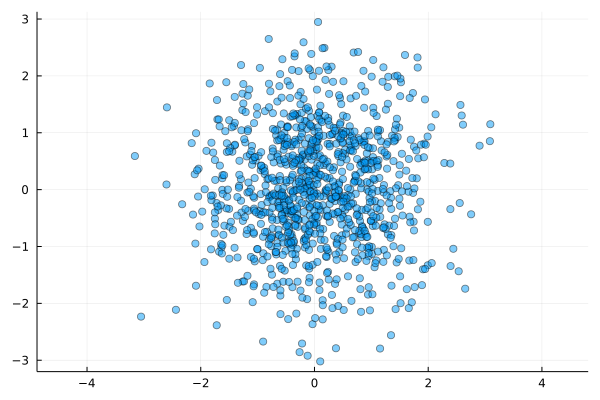

In [ ]:
scatter(points[1, :], points[2,:], alpha=0.5, label="", aspectratio=:equal)

## Optimal solution

In [ ]:
## spiral
θmin = 1.5π
θmax = 4.5π
xmax = 4.5π
xmin = -3.5π
x_func(t) = t * cos(t) 
y_func(t) = t * sin(t)

## normalize
scale = 2/(xmax - xmin)
shift = -1 - scale * xmin

x_func_norm(t) = scale * x_func(t) + shift
y_func_norm(t) = scale * y_func(t) + shift

θ = (θmin:0.01:θmax)
x = x_func_norm.(θ);
y = y_func_norm.(θ);

In [ ]:
f(p, t)   = (x_func_norm(t) - p[1])^2 + (y_func_norm(t) - p[2])^2;
## spiral
df(p, t)  = t * scale + (shift - p[1]) * (cos(t) - t * sin(t)) + (shift - p[2]) * (sin(t) + t * cos(t));
ddf(p, t) = 1 * scale - (shift - p[1]) * (2sin(t) + t * cos(t)) + (shift - p[2]) * (2cos(t) - t * sin(t));
## solver
solver(p) = argmin_func_newton(t->f(p, t), t->df(p, t), t->ddf(p, t), θmin, θmax, length=100)
#solver(p) = argmin_func_bisection(t->f(p, t), t->df(p, t), θmin, θmax, length=1000)

solver (generic function with 1 method)

In [ ]:
θs = [solver(points[:, i]) for i in 1:num_samples]
x0s = x_func_norm.(θs)
y0s = y_func_norm.(θs)
X0s = permutedims(hcat(x0s, y0s));

┌ Warning: gradient=-0.1105797335113227 is too low for Newton's method. Returning seed without optimization.
└ @ Main C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion-examples\utilities.jl:76
┌ Warning: gradient=-0.17005478452714962 is too low for Newton's method. Returning seed without optimization.
└ @ Main C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion-examples\utilities.jl:76
┌ Warning: gradient=0.18077729745044657 is too low for Newton's method. Returning seed without optimization.
└ @ Main C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion-examples\utilities.jl:76
┌ Warning: gradient=0.14012636497632164 is too low for Newton's method. Returning seed without optimization.
└ @ Main C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion-examples\utilities.jl:76
┌ Warning: gradient=0.02928342662595909 is too low for Newton's method. Returning seed without optimization.
└ @ Main C:\Users\sinai\Documents\Projects\Jul

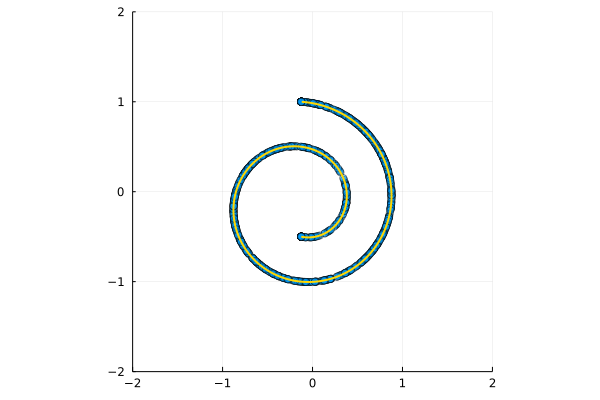

In [ ]:
p = scatter(X0s[1, :], X0s[2, :], alpha=0.5, label="", aspectratio=:equal, xlims=(-2, 2), ylims=(-2, 2))
#scatter!(p, points[1, :], points[2,:], alpha=0.5)
plot!(p, x, y, label="", linewidth=2, color=:gold)

Starting similarity: 0.5154


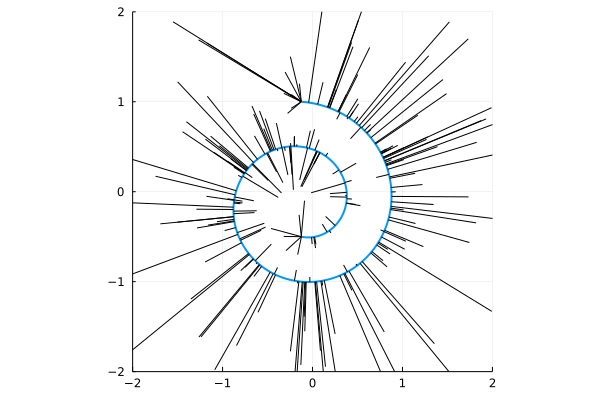

In [ ]:
n = 200
p = plot(x, y, linewidth=2, aspectratio=:equal, label="", xlims=(-2, 2), ylims=(-2, 2))
for i in 1:n
    plot!(p, [points[1, i] ; X0s[1, i]], [points[2, i]; X0s[2, i]], label="", color=:black )
end
closest_distances = [sqrt(f(points[:, i], θs[i])) for i in 1:num_samples]
similarities = mean(closest_distances)
@printf("Starting similarity: %.4f\n", similarities)
p

## Animations

In [ ]:
num_timesteps = 40;

In [ ]:
# sub-optimal: update at every iteration
XT = points
X_opt = Array{Float32}(undef, size(XT)..., 0)
X = XT
@time for timestep in 1:num_timesteps
    θs = [solver(X[:, i]) for i in 1:num_samples]
    x0 = x_func_norm.(θs)
    y0 = y_func_norm.(θs)
    X0 = permutedims(hcat(x0, y0))
    X += 1/(num_timesteps - timestep + 1) * (X0 - X)
    X_opt = cat(X_opt, X, dims=3)
end

  3.524415 seconds (80.32 M allocations: 1.455 GiB, 9.40% gc time, 25.93% compilation time)


┌ Warning: gradient=-0.1105797335113227 is too low for Newton's method. Returning seed without optimization.
└ @ Main C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion-examples\utilities.jl:76
┌ Warning: gradient=-0.17005478452714962 is too low for Newton's method. Returning seed without optimization.
└ @ Main C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion-examples\utilities.jl:76
┌ Warning: gradient=0.18077729745044657 is too low for Newton's method. Returning seed without optimization.
└ @ Main C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion-examples\utilities.jl:76
┌ Warning: gradient=0.14012636497632164 is too low for Newton's method. Returning seed without optimization.
└ @ Main C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion-examples\utilities.jl:76
┌ Warning: gradient=0.02928342662595909 is too low for Newton's method. Returning seed without optimization.
└ @ Main C:\Users\sinai\Documents\Projects\Jul

In [ ]:
# optimal: predetermined at start
XT = points
X_opt = Array{Float32}(undef, size(XT)..., 0)
for timestep in 1:num_timesteps
    z = XT + timestep/num_timesteps * (X0s - XT)
    X_opt = cat(X_opt, z, dims=3)
end

In [ ]:
X_opt[:, 365:370, 1]

2×6 Matrix{Float64}:
 -0.383459  -1.26223  -1.23954  0.19473   -0.679705  0.719934
 -1.69787    2.16142   1.38876  0.458988  -1.09235   0.260399

In [ ]:
anim_optimal = @animate for i ∈ 1:(num_timesteps + 10)
    i = i > num_timesteps ? num_timesteps : i
    scatter(X_opt[1, :, i], X_opt[2,:, i], 
        alpha=0.5, 
        title="i=$i", 
        label="",
        aspectratio=:equal,
        xlims=(-2, 2), ylims=(-2, 2),
        figsize=(400, 400),
    )
end

Animation("C:\\Users\\sinai\\AppData\\Local\\Temp\\jl_jda7jM", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000041.png", "000042.png", "000043.png", "000044.png", "000045.png", "000046.png", "000047.png", "000048.png", "000049.png", "000050.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion-examples\outputs\spiral_optimal.gif
└ @ Plots C:\Users\sinai\.julia\packages\Plots\1KWPG\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\sinai\\Documents\\Projects\\Julia projects\\DenoisingDiffusion-examples\\outputs\\spiral_optimal.gif")
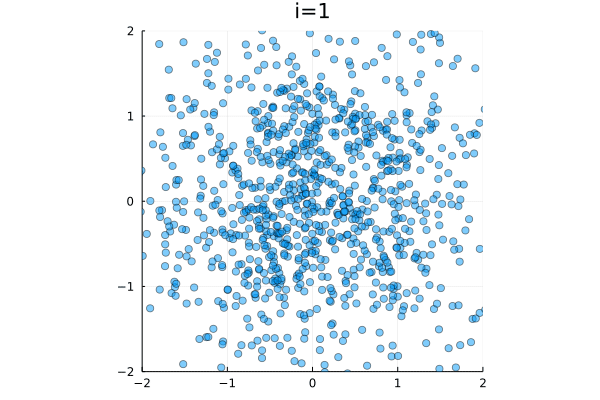

In [ ]:
gif(anim_optimal, joinpath("../outputs", "spiral_optimal.gif"), fps=8)

## Newton's Method

In [ ]:
colors = theme_palette(:auto)

In [ ]:
idx = rand(1:size(points, 2), 1)
point = points[:, idx];
#point = [1.5, 1.5];
#point = [-0.13, -0.06]; # failure case
point = [-0.24, -0.025]; # failure case
point = [1.5, 1.5];
#point = [-1, 1.2];

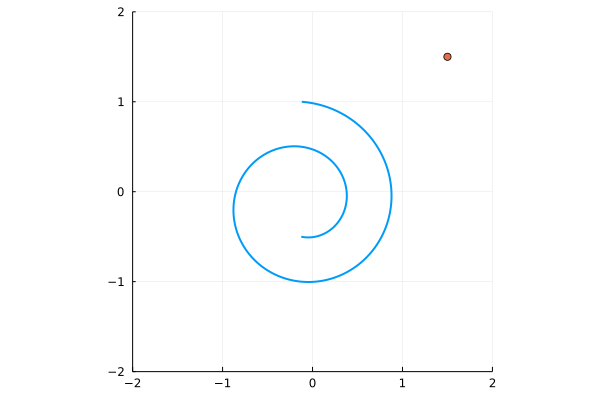

In [ ]:
p = plot(x, y, label="", linewidth=2)
scatter!(p, [point[1]], [point[2]], alpha=1, label="", aspectratio=:equal, xlims=(-2, 2), ylims=(-2, 2))
savefig("../outputs/spiral_closest_1.png")
p

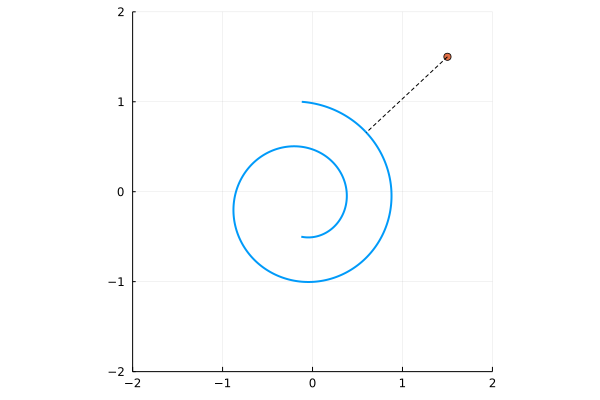

In [ ]:
θopt =argmin_func_newton(t->f(point, t), t->df(point, t), t->ddf(point, t), θmin, θmax, length=20)
#scatter!(p, points[1, :], points[2,:], alpha=0.5)
p = plot(x, y, label="", linewidth=2)
scatter!(p, [point[1]], [point[2]], alpha=1, label="", aspectratio=:equal, xlims=(-2, 2), ylims=(-2, 2))
plot!(p, [point[1], x_func_norm(θopt)], [point[2], y_func_norm(θopt)], color=:black, linestyle=:dash, label="")
scatter!(p, [x_func_norm(θopt)], [ y_func_norm(θopt)], alpha=0, label="", markershape=:none)

savefig(p, "../outputs/spiral_closest_2.png")
p

Newton's method

In [ ]:
root = argmin(θ -> f(point, θ), range(θmin, θmax, 10))
ddf(point, root)

27.946994831590725

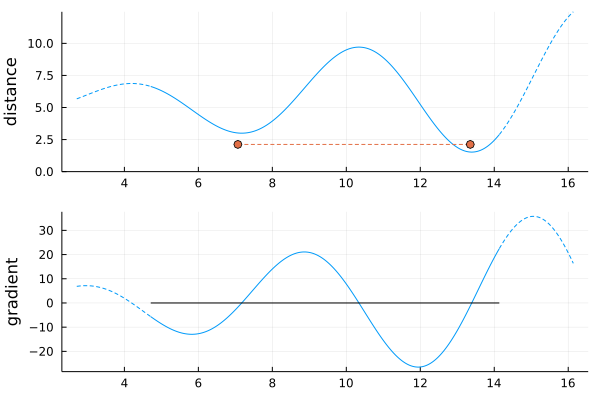

In [ ]:
candidate = atan(point[2], point[1])
θpoints = (candidate - 4π):2π:(candidate + 4π)
θpoints = [θ for θ in θpoints if ((θ >= (θmin - 2) && (θ <= (θmax + 2))))]
#θpoints = clamp.(θpoints, θmin, θmax)
r = sqrt(point[1]^2 + point[2]^2)
rpoints = [r for θ in θpoints]

θrange = θmin:0.01:θmax
distances = [f(point, θ) for θ in θrange]
grads = [df(point, θ) for θ in θrange]

θlower = (θmin - 2):0.01:θmin
distances_lower = [f(point, θ) for θ in θlower]
grads_lower = [df(point, θ) for θ in θlower]
        
θupper = θmax:0.01:(θmax + 2)
distances_upper = [f(point, θ) for θ in θupper]
grads_upper = [df(point, θ) for θ in θupper]

distance_plot = plot(θrange, distances, ylabel="distance", label="", ylims=(0, Inf), color=colors[1])
plot!(distance_plot, θpoints, rpoints, alpha=1, label="", marker=:o, linestyle=:dash, color=colors[2])
plot!(distance_plot, θlower, distances_lower, alpha=1, label="", linestyle=:dash, color=colors[1])
plot!(distance_plot, θupper, distances_upper, alpha=1, label="", linestyle=:dash, color=colors[1])

grad_plot = plot(θrange, grads, ylabel="gradient", label="", xlims=xlims(distance_plot), color=colors[1])
plot!(grad_plot, [θmin, θmax], [0, 0], color=:black, label="")
plot!(grad_plot, θlower, grads_lower, alpha=1, label="", linestyle=:dash, color=colors[1])
plot!(grad_plot, θupper, grads_upper, alpha=1, label="", linestyle=:dash, color=colors[1])

ylims_grad = ylims(grad_plot)
plot(distance_plot, grad_plot, layout=(2, 1))

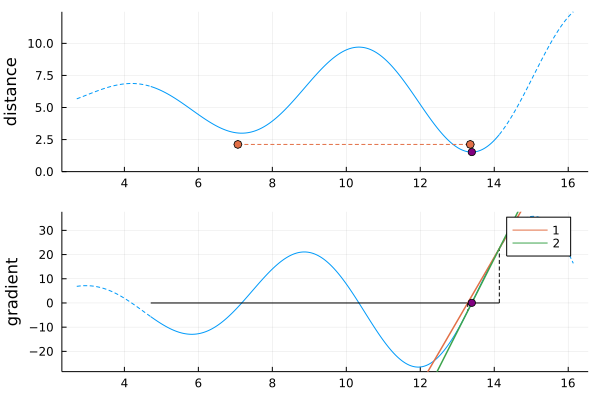

In [ ]:
#y = mθ +c 
root = argmin(θ -> f(point, θ), range(θmin, θmax, 5))
for i in 1:2
    plot!(grad_plot, [root, root], [0, df(point, root)], color=:black, linestyle=:dash, label="")
    m = ddf(point, root)
    c = df(point, root) - m * root
    ymin = m * θlower[1] + c
    ymax = m * θupper[end] + c
    plot!(grad_plot, [θlower[1], θupper[end]], [ymin, ymax], label="$i", linewidth=1.5, color=colors[i+1])
    root = root - df(point, root)/ddf(point, root)
end
root = clamp(root, θmin, θmax)
plot!(grad_plot, [root, root], [0, df(point, root)], color=:black, linestyle=:dash, label="")
scatter!(grad_plot, [root], [df(point, root)], label="", color=:purple, ylims=ylims_grad)
scatter!(distance_plot, [root], [f(point, root)], label="", color=:purple)
#plot!(grad_plot, ylim=ylims_base)

p = plot(distance_plot, grad_plot, layout=(2, 1))
savefig(p, "../outputs/newtons_method_grad.png")
p